# Self-Consistency

A simple idea makes chain-of-thought far more reliable: instead of generating one reasoning chain and hoping it's right, generate *many* chains and see which answer comes up most often.

It's like asking 10 experts to solve a problem independently, then going with the majority opinion.

## The Problem with Single Samples

In the last notebook, we saw that chain-of-thought prompting dramatically improves reasoning. But there's a catch: the model might generate a wrong reasoning chain.

Consider this:

```
Q: What's 23 × 17?

Chain 1: 23 × 17 = 23 × 10 + 23 × 7 = 230 + 161 = 391 ✓
Chain 2: 23 × 17 = 20 × 17 + 3 × 17 = 340 + 51 = 391 ✓  
Chain 3: 23 × 17 = 23 × 20 - 23 × 3 = 460 - 69 = 391 ✓
Chain 4: 23 × 17 = 25 × 17 - 2 × 17 = 425 - 34 = 389 ✗ (arithmetic error!)
```

If we only sample Chain 4, we get the wrong answer. But if we sample all four and take the majority, we get 391 (correct!).

This is the core insight of **self-consistency**: the correct answer tends to be more robust across different reasoning paths.

## The Algorithm

Self-consistency is straightforward:

1. **Sample** $N$ independent reasoning chains from the model
2. **Extract** the final answer from each chain
3. **Vote** — take the most common answer

No training. No new models. Just sample more.

```
┌─────────────────┐
│    Question     │
└────────┬────────┘
         │
         ▼  (sample N times with temperature > 0)
┌─────────────────────────────────────────────────────┐
│  Chain 1 → 391    Chain 2 → 391    Chain 3 → 391   │
│  Chain 4 → 389    Chain 5 → 391    Chain 6 → 391   │
└────────────────────────┬────────────────────────────┘
                         │
                         ▼  (majority vote)
                   ┌───────────┐
                   │    391    │
                   └───────────┘
```

In [1]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
from collections import Counter
import re

# Load model
model_name = "Qwen/Qwen2.5-1.5B-Instruct"
print(f"Loading {model_name}...")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, dtype="auto")

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

print(f"Loaded on {device}")

Loading Qwen/Qwen2.5-1.5B-Instruct...


Loaded on cuda


In [2]:
def extract_number(text: str) -> str:
    """
    Extract the final numerical answer from reasoning text.

    Tries several patterns, falls back to last number found.
    """
    # Try common answer patterns (order matters - more specific first)
    patterns = [
        r"(?:the answer is|answer:)\s*(\d+(?:\.\d+)?)",
        r"(?:therefore|thus|so)[,\s]+(?:the answer is\s*)?(\d+(?:\.\d+)?)",
        r"=\s*(\d+(?:\.\d+)?)\s*(?:\.|$)",
        r"(\d+(?:\.\d+)?)\s*(?:total|in all|altogether)",
    ]

    text_lower = text.lower()
    for pattern in patterns:
        match = re.search(pattern, text_lower)
        if match:
            return match.group(1)

    # Fallback: last number in the text
    numbers = re.findall(r"\b\d+\.?\d*\b", text)
    if numbers:
        return numbers[-1]

    return None


def generate_chain(prompt: str, max_new_tokens: int = 100,
                   temperature: float = 0.7) -> str:
    """
    Generate a single reasoning chain.

    Args:
        prompt: The CoT prompt
        max_new_tokens: Max tokens to generate
        temperature: Sampling temperature (>0 for diversity)

    Returns:
        The generated reasoning chain
    """
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
        )

    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return full_response[len(prompt):].strip()


# Test single generation
test_prompt = "Question: What is 5 + 7?\nAnswer: Let's think step by step."
chain = generate_chain(test_prompt)
print(f"Generated chain: {chain}")
print(f"Extracted answer: {extract_number(chain)}")

Generated chain: First, we need to add the numbers together: 5 + 7 = 12.
Therefore, the answer is 12.
Extracted answer: 12


## Implementing Self-Consistency

Now let's build the full self-consistency pipeline.

In [3]:
class SelfConsistency:
    """
    Self-Consistency for chain-of-thought reasoning.
    
    Sample multiple reasoning paths, extract answers, take majority vote.
    """
    
    def __init__(self, model, tokenizer, device="cuda"):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
    
    def sample_chains(self, prompt: str, n_samples: int = 5,
                      max_new_tokens: int = 100,
                      temperature: float = 0.7) -> list:
        """
        Generate N independent reasoning chains.
        
        Args:
            prompt: The CoT prompt
            n_samples: Number of chains to generate
            max_new_tokens: Max tokens per chain
            temperature: Sampling temperature (higher = more diversity)
        
        Returns:
            List of (chain, extracted_answer) tuples
        """
        chains = []
        
        for i in range(n_samples):
            chain = generate_chain(
                prompt, 
                max_new_tokens=max_new_tokens,
                temperature=temperature
            )
            answer = extract_number(chain)
            chains.append((chain, answer))
        
        return chains
    
    def majority_vote(self, answers: list) -> tuple:
        """
        Take majority vote across answers.
        
        Args:
            answers: List of extracted answers (some may be None)
        
        Returns:
            (most_common_answer, vote_count, total_valid)
        """
        # Filter out None answers
        valid_answers = [a for a in answers if a is not None]
        
        if not valid_answers:
            return None, 0, 0
        
        # Count votes
        counter = Counter(valid_answers)
        most_common, count = counter.most_common(1)[0]
        
        return most_common, count, len(valid_answers)
    
    def solve(self, question: str, n_samples: int = 5,
              max_new_tokens: int = 100,
              temperature: float = 0.7) -> dict:
        """
        Solve a problem using self-consistency.
        
        Args:
            question: The problem to solve
            n_samples: Number of reasoning chains to sample
            max_new_tokens: Max tokens per chain
            temperature: Sampling temperature
        
        Returns:
            Dict with answer, confidence, chains, and vote details
        """
        # Build CoT prompt
        prompt = f"Question: {question}\nAnswer: Let's think step by step."
        
        # Sample chains
        chains = self.sample_chains(
            prompt, 
            n_samples=n_samples,
            max_new_tokens=max_new_tokens,
            temperature=temperature
        )
        
        # Extract answers and vote
        answers = [answer for _, answer in chains]
        final_answer, votes, total_valid = self.majority_vote(answers)
        
        # Calculate confidence as vote fraction
        confidence = votes / total_valid if total_valid > 0 else 0.0
        
        return {
            "answer": final_answer,
            "confidence": confidence,
            "votes": votes,
            "total_samples": n_samples,
            "valid_samples": total_valid,
            "chains": chains,
            "vote_distribution": Counter(answers)
        }


# Create self-consistency solver
sc = SelfConsistency(model, tokenizer, device=device)
print("Self-consistency solver ready.")

Self-consistency solver ready.


In [4]:
# Test self-consistency on a math problem
# Note: With a small 1.5B model, the model often gets multi-step arithmetic wrong.
# This actually demonstrates WHY self-consistency matters - and its limitations
# when the base model accuracy is below 50%!

question = "A store has 45 books. They sell 12 and receive 30 more. How many books do they have?"

print(f"Question: {question}")
print(f"Correct answer: 45 - 12 + 30 = 63")
print("\n" + "="*70)
print("Sampling 5 reasoning chains...")
print("="*70 + "\n")

result = sc.solve(question, n_samples=5, temperature=0.8)

# Show each chain
for i, (chain, answer) in enumerate(result["chains"], 1):
    print(f"Chain {i}: {chain[:80]}...")
    print(f"  → Extracted answer: {answer}")
    print()

print("="*70)
print(f"Vote distribution: {dict(result['vote_distribution'])}")
print(f"Final answer: {result['answer']}")
print(f"Confidence: {result['confidence']:.1%} ({result['votes']}/{result['valid_samples']} votes)")

Question: A store has 45 books. They sell 12 and receive 30 more. How many books do they have?
Correct answer: 45 - 12 + 30 = 63

Sampling 5 reasoning chains...



Chain 1: The number of books is increased from 45 to 45 + 30 = 75. If the store then sell...
  → Extracted answer: 75

Chain 2: The store starts with 45 books, sells 12, so they have 45 - 12 = 33 books left. ...
  → Extracted answer: 63

Chain 3: The store starts with 45 books. Then they sell 12, so now they have 45 - 12 = 33...
  → Extracted answer: 5

Chain 4: First, the store starts with 45 books. Then it sells 12 so now there are 45 - 12...
  → Extracted answer: 4

Chain 5: The store starts with 45 books, sells 12 leaving them with 45 - 12 = 33 books. T...
  → Extracted answer: 63

Vote distribution: {'75': 1, '63': 2, '5': 1, '4': 1}
Final answer: 63
Confidence: 40.0% (2/5 votes)


## The Math Behind Self-Consistency

Why does majority voting work? Let's think about it probabilistically.

Suppose the model has probability $p$ of generating a correct reasoning chain. If we sample $N$ chains and vote:

$$P(\text{majority correct}) = \sum_{k=\lceil N/2 \rceil}^{N} \binom{N}{k} p^k (1-p)^{N-k}$$

This is just the binomial distribution. For $p > 0.5$ (the model is more often right than wrong), majority voting *amplifies* accuracy.

**Example:**
- Model accuracy per chain: $p = 0.6$
- With 1 sample: 60% chance of correct answer
- With 5 samples (majority vote): ~68% chance of correct answer
- With 10 samples: ~74% chance
- With 40 samples: ~90% chance

The more you sample, the more reliable the answer—as long as the model is better than random.

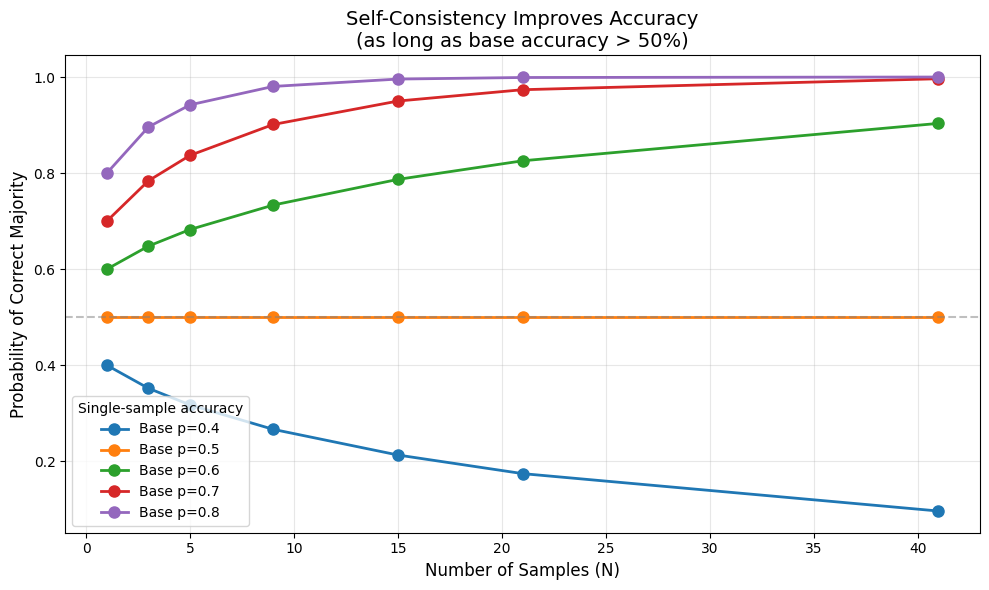

Key insight: If the model is right more often than not (p > 0.5),
sampling more chains and voting will push accuracy toward 100%.

But if p < 0.5, voting makes things WORSE!


In [5]:
from scipy import stats
import matplotlib.pyplot as plt

def majority_vote_accuracy(p, n):
    """
    Calculate probability that majority vote gives correct answer.
    
    Args:
        p: Probability each individual sample is correct
        n: Number of samples
    
    Returns:
        Probability of correct majority
    """
    # Need more than half to be correct
    # For n samples, we need at least ceil(n/2) correct
    k_min = (n // 2) + 1
    
    # Sum probability of getting k_min, k_min+1, ..., n correct
    return 1 - stats.binom.cdf(k_min - 1, n, p)


# Plot the improvement from self-consistency
sample_sizes = [1, 3, 5, 9, 15, 21, 41]
base_accuracies = [0.4, 0.5, 0.6, 0.7, 0.8]

plt.figure(figsize=(10, 6))

for p in base_accuracies:
    accuracies = [majority_vote_accuracy(p, n) for n in sample_sizes]
    plt.plot(sample_sizes, accuracies, 'o-', label=f'Base p={p}', linewidth=2, markersize=8)

plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Number of Samples (N)', fontsize=12)
plt.ylabel('Probability of Correct Majority', fontsize=12)
plt.title('Self-Consistency Improves Accuracy\n(as long as base accuracy > 50%)', fontsize=14)
plt.legend(title='Single-sample accuracy')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Key insight: If the model is right more often than not (p > 0.5),")
print("sampling more chains and voting will push accuracy toward 100%.")
print("\nBut if p < 0.5, voting makes things WORSE!")

## Diversity Matters: Temperature

For self-consistency to work, we need the reasoning chains to be *different*. If we sample 10 identical chains, voting is useless.

This is why **temperature** matters.

Temperature controls how "random" the sampling is:
- **Temperature = 0**: Always pick the most likely token (deterministic)
- **Temperature = 0.7**: Some randomness (typical for creative tasks)
- **Temperature = 1.0**: Full probability distribution
- **Temperature > 1.0**: Even more random (often incoherent)

For self-consistency, we typically use temperature 0.7-0.8. This gives enough diversity to explore different reasoning paths while keeping each chain coherent.

In [6]:
# Demonstrate the effect of temperature on diversity
question = "What is 15 + 27?"
prompt = f"Question: {question}\nAnswer: Let's think step by step."

temperatures = [0.3, 0.7, 1.0]

for temp in temperatures:
    print(f"\n{'='*60}")
    print(f"Temperature = {temp}")
    print("="*60)
    
    chains = []
    for i in range(3):
        chain = generate_chain(prompt, max_new_tokens=50, temperature=temp)
        chains.append(chain)
        print(f"\nSample {i+1}: {chain[:60]}...")
    
    # Check diversity: how many unique answers?
    answers = [extract_number(c) for c in chains]
    unique = len(set(a for a in answers if a is not None))
    print(f"\nUnique answers: {unique}/3")


Temperature = 0.3



Sample 1: The first number in the addition problem is fifteen, and the...



Sample 2: First, we need to add the two numbers together. We can do th...



Sample 3: First, we need to add the two numbers together. We can do th...

Unique answers: 3/3

Temperature = 0.7



Sample 1: We know that 10 + 10 = 20, so we can subtract one ten from b...



Sample 2: First, we need to add the two numbers together. We can do th...



Sample 3: We need to add the two numbers together, so we can start wit...

Unique answers: 2/3

Temperature = 1.0



Sample 1: 15 plus twenty seven equals thirty two.
Therefore, the answe...



Sample 2: First, we add the numbers together:
15 + 27 = 42
Therefore, ...



Sample 3: The sum of 15 and 27 equals 42.

The answer is 42....

Unique answers: 2/3


## The Cost Trade-off

Self-consistency improves accuracy, but at a cost:

| Metric | Single Chain | 5 Samples | 10 Samples | 40 Samples |
|--------|-------------|-----------|------------|------------|
| Tokens generated | 1× | 5× | 10× | 40× |
| Latency | 1× | ~5× | ~10× | ~40× |
| API cost | 1× | 5× | 10× | 40× |

(Latency can be reduced with parallel sampling, but cost scales linearly.)

Is it worth it? Depends on your use case:

- **High-stakes decisions**: Yes! Sample 40+ chains.
- **Math competitions/exams**: Absolutely.
- **Casual chat**: Probably overkill.
- **Real-time applications**: Probably not feasible.

The original paper used 40 samples for their best results. But even 5-10 samples gives substantial improvement.

## Weighted Voting

Basic self-consistency treats all chains equally. But what if some chains are more "trustworthy" than others?

**Weighted self-consistency** assigns weights to each chain, typically based on:

1. **Token probabilities**: Chains where the model was more confident get higher weight
2. **Length**: Longer, more detailed chains might be more reliable
3. **Verifier scores**: Use a trained model to score chain quality

The third option leads us toward **Process Reward Models**—but that's a later notebook.

For now, let's implement probability-weighted voting.

In [7]:
def generate_chain_with_score(prompt: str, max_new_tokens: int = 100,
                               temperature: float = 0.7) -> tuple:
    """
    Generate a chain and compute its log probability.
    
    The log probability indicates how "confident" the model was
    when generating this particular chain.
    
    Returns:
        (chain_text, log_probability)
    """
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    input_len = inputs["input_ids"].shape[1]
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
            return_dict_in_generate=True,
            output_scores=True,
        )
    
    # Get generated token IDs (excluding prompt)
    generated_ids = outputs.sequences[0, input_len:]
    
    # Compute log probability of the generated sequence
    # scores[i] has shape (batch, vocab) for token i
    log_prob = 0.0
    for i, token_id in enumerate(generated_ids):
        if i >= len(outputs.scores):
            break
        logits = outputs.scores[i][0]  # Shape: (vocab_size,)
        log_probs = torch.log_softmax(logits, dim=-1)
        log_prob += log_probs[token_id].item()
    
    # Normalize by length (average log prob per token)
    avg_log_prob = log_prob / max(len(generated_ids), 1)
    
    # Decode the chain
    chain = tokenizer.decode(generated_ids, skip_special_tokens=True)
    
    return chain, avg_log_prob


def weighted_majority_vote(chains_with_scores: list) -> tuple:
    """
    Weighted majority vote based on log probabilities.
    
    Args:
        chains_with_scores: List of (chain, answer, log_prob) tuples
    
    Returns:
        (best_answer, weight_sum, total_weight)
    """
    from collections import defaultdict
    
    # Convert log probs to weights (using softmax for stability)
    log_probs = [lp for _, _, lp in chains_with_scores]
    
    # Softmax: exp(log_prob) / sum(exp(log_probs))
    max_lp = max(log_probs)
    exp_lps = [np.exp(lp - max_lp) for lp in log_probs]  # Subtract max for stability
    total = sum(exp_lps)
    weights = [e / total for e in exp_lps]
    
    # Weighted vote
    answer_weights = defaultdict(float)
    for (_, answer, _), weight in zip(chains_with_scores, weights):
        if answer is not None:
            answer_weights[answer] += weight
    
    if not answer_weights:
        return None, 0, 0
    
    best_answer = max(answer_weights, key=answer_weights.get)
    return best_answer, answer_weights[best_answer], sum(answer_weights.values())


# Demo weighted voting
print("Generating chains with confidence scores...\n")

question = "What is 8 + 15?"
prompt = f"Question: {question}\nAnswer: Let's think step by step."

chains_with_scores = []
for i in range(5):
    chain, log_prob = generate_chain_with_score(prompt, max_new_tokens=50)
    answer = extract_number(chain)
    chains_with_scores.append((chain, answer, log_prob))
    print(f"Chain {i+1}:")
    print(f"  Text: {chain[:50]}...")
    print(f"  Answer: {answer}")
    print(f"  Avg log prob: {log_prob:.3f}")
    print()

# Compare voting methods
answers = [a for _, a, _ in chains_with_scores]
unweighted_answer, votes, _ = sc.majority_vote(answers)
weighted_answer, weight, _ = weighted_majority_vote(chains_with_scores)

print("="*50)
print(f"Unweighted vote: {unweighted_answer}")
print(f"Weighted vote:   {weighted_answer}")
print(f"Correct answer:  23")

Generating chains with confidence scores...



Chain 1:
  Text:  The question asks us to add two numbers together,...
  Answer: 15
  Avg log prob: -0.363



Chain 2:
  Text:  The first number, 8, plus the second number, 15, ...
  Answer: 23
  Avg log prob: -0.179



Chain 3:
  Text:  The sum of eight and fifteen is twenty-three. So,...
  Answer: 12
  Avg log prob: -0.584



Chain 4:
  Text:  The sum of 8 and 15 is calculated as follows:
$$
...
  Answer: 23
  Avg log prob: -0.242



Chain 5:
  Text:  First, we need to add the two numbers together: 8...
  Answer: 23
  Avg log prob: -0.119

Unweighted vote: 23
Weighted vote:   23
Correct answer:  23


## Benchmark Results

From the original self-consistency paper (Wang et al., 2022):

| Benchmark | CoT (1 sample) | Self-Consistency (40 samples) | Improvement |
|-----------|----------------|------------------------------|-------------|
| GSM8K | 56.5% | 74.4% | +17.9% |
| SVAMP | 78.7% | 86.6% | +7.9% |
| AQuA | 48.0% | 52.0% | +4.0% |
| ASDiv | 79.6% | 87.0% | +7.4% |

(Results with GPT-3 text-davinci-002)

The gains are particularly strong on harder benchmarks (GSM8K) where the base CoT accuracy is lower. Self-consistency helps more when there's more room for improvement.

## Efficient Self-Consistency: Early Stopping

One optimization: we don't always need all $N$ samples.

If the first 5 samples all give the same answer, we can be pretty confident. Why sample 35 more?

**RASC (Reasoning-Aware Self-Consistency)** does exactly this:
1. Sample chains sequentially
2. Track a running confidence score
3. Stop when confidence exceeds a threshold

This can reduce compute by 40%+ while maintaining accuracy.

In [8]:
def self_consistency_early_stop(question: str, max_samples: int = 20,
                                 confidence_threshold: float = 0.8,
                                 min_samples: int = 3) -> dict:
    """
    Self-consistency with early stopping.

    Stop sampling when we're confident enough in the answer.

    Args:
        question: The problem to solve
        max_samples: Maximum chains to generate
        confidence_threshold: Stop if vote share exceeds this
        min_samples: Always generate at least this many

    Returns:
        Dict with answer, samples_used, and chains
    """
    prompt = f"Question: {question}\nAnswer: Let's think step by step."

    chains = []
    answers = []

    for i in range(max_samples):
        # Generate one chain
        chain = generate_chain(prompt, max_new_tokens=80, temperature=0.7)
        answer = extract_number(chain)

        chains.append(chain)
        answers.append(answer)

        # Check if we can stop early
        if i + 1 >= min_samples:
            valid = [a for a in answers if a is not None]
            if valid:
                counter = Counter(valid)
                top_answer, top_count = counter.most_common(1)[0]
                confidence = top_count / len(valid)

                if confidence >= confidence_threshold:
                    return {
                        "answer": top_answer,
                        "confidence": confidence,
                        "samples_used": i + 1,
                        "max_samples": max_samples,
                        "early_stopped": True,
                        "chains": list(zip(chains, answers))
                    }

    # Didn't stop early—use all samples
    valid = [a for a in answers if a is not None]
    if valid:
        counter = Counter(valid)
        top_answer, top_count = counter.most_common(1)[0]
        confidence = top_count / len(valid)
    else:
        top_answer, confidence = None, 0.0

    return {
        "answer": top_answer,
        "confidence": confidence,
        "samples_used": max_samples,
        "max_samples": max_samples,
        "early_stopped": False,
        "chains": list(zip(chains, answers))
    }


# Demo early stopping
# Note: The small model often gets this wrong - demonstrating that self-consistency
# only helps when base accuracy > 50%. This motivates the techniques in later notebooks!
print("Testing self-consistency with early stopping...\n")

question = "A farmer has 30 cows. He sells 10 and buys 15 more. How many cows does he have?"
print(f"Question: {question}")
print(f"Correct: 30 - 10 + 15 = 35\n")

result = self_consistency_early_stop(
    question,
    max_samples=10,
    confidence_threshold=0.7
)

print(f"Answer: {result['answer']}")
print(f"Confidence: {result['confidence']:.1%}")
print(f"Samples used: {result['samples_used']}/{result['max_samples']}")
print(f"Early stopped: {result['early_stopped']}")

if result['early_stopped']:
    savings = (result['max_samples'] - result['samples_used']) / result['max_samples']
    print(f"Compute saved: {savings:.0%}")

Testing self-consistency with early stopping...

Question: A farmer has 30 cows. He sells 10 and buys 15 more. How many cows does he have?
Correct: 30 - 10 + 15 = 35



Answer: 35
Confidence: 100.0%
Samples used: 3/10
Early stopped: True
Compute saved: 70%


## Limitations of Self-Consistency

Self-consistency is powerful but has limits:

### 1. Requires p > 0.5

If the model gets it wrong more often than right, voting makes things *worse*. The majority will be wrong!

### 2. All-or-Nothing Answers

Voting works great for problems with discrete answers (numbers, multiple choice). For open-ended generation, it's not clear how to "vote" between different phrasings.

### 3. No Reasoning Verification

We vote on the *answer*, not the *reasoning*. Two chains might reach the same answer for completely different reasons—one correct, one flawed. Voting doesn't distinguish them.

### 4. Linear Compute Cost

Sampling 40 chains costs 40× as much as sampling 1. For latency-sensitive applications, this can be prohibitive.

---

These limitations motivate more sophisticated approaches:

- **Tree of Thoughts**: Explore reasoning paths more efficiently
- **Process Reward Models**: Verify the reasoning, not just the answer
- **MCTS**: Smart search instead of brute-force sampling

## What We've Learned

Self-consistency is a simple, powerful technique:

1. **Sample** multiple reasoning chains with temperature > 0
2. **Extract** answers from each chain
3. **Vote** — majority wins

The math: if individual accuracy is $p > 0.5$, majority voting amplifies accuracy.

$$P(\text{majority correct}) = \sum_{k=\lceil N/2 \rceil}^{N} \binom{N}{k} p^k (1-p)^{N-k}$$

Practical tips:
- Use temperature 0.7-0.8 for diversity
- 5-10 samples often enough; 40 for best results
- Consider early stopping to save compute
- Weighted voting can help but adds complexity

**Next up:** Tree of Thoughts — what if we could explore reasoning paths more intelligently?